In [16]:
library(pacman)
p_load(dplyr,glarma,boot)

In [17]:
setwd('C:\\Users\\Marcelo\\OneDrive\\Área de Trabalho\\ts\\glarma')
getwd()

[1] "C:/Users/Marcelo/OneDrive/Área de Trabalho/ts/glarma"

# Simulação

Criando a função que simula o processo:

In [179]:
simulate_glarma <- function(T = 100, beta = 1, phi = 0, theta = 0.3, x = NULL) {
  if (is.null(x)) x <- rep(1, T)
  
  z <- numeric(T)
  mu <- numeric(T)
  y <- numeric(T)
  e <- numeric(T)
  
  for (t in 1:T) {
    z_t <- 0
    if (t > 1) z_t <- z[t - 1] * phi + e[t - 1] * theta
    
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    y[t] <- rpois(1, lambda = mu[t])
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
  return(data.frame(time = 1:T, x = x, y = y, mu = mu, z = z,e=e))
}

In [27]:
Amostra_original<-simulate_glarma(T=100,beta=1,phi=0,theta=0.3,x=NULL)

In [28]:
length(Amostra_original$y)

[1] 100

In [29]:
summary(Amostra_original$y)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     2.0     2.5     2.9     4.0     8.0 

In [30]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [31]:
result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")

In [32]:
Theta<-result$delta[2]
Theta

theta_1 
0.3374409

In [33]:
Beta<-result$delta[1]
Beta

Intercept 
 1.017005

# Bootstrap paramétrico:

In [45]:
B=100

In [46]:
T=length(Amostra_original$y)

gerando as amostras bootstrap:

In [47]:
mu<-Amostra_original$mu

In [48]:
length(mu)

[1] 100

In [49]:
Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

In [50]:
for (b in 1:B){
    r = simulate_glarma(T=T,beta=0.5,phi=0,theta=Theta,x=NULL) 
    Y_Bootstrap[,b] <- r$y
    }

Estimando os parâmetros para cada amostra:

In [51]:
recupera_par<- function(Y_col){
    fit<-glarma(Y_col, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    return(fit$delta[2])}

In [53]:
Theta_estimates <- apply(Y_Bootstrap, 2, recupera_par)

In [54]:
mean(Theta_estimates)

[1] 0.336877

In [91]:
quantile(Theta_estimates,probs=c(0.025,0.975))

2.5%     97.5% 
0.2422851 0.4322252

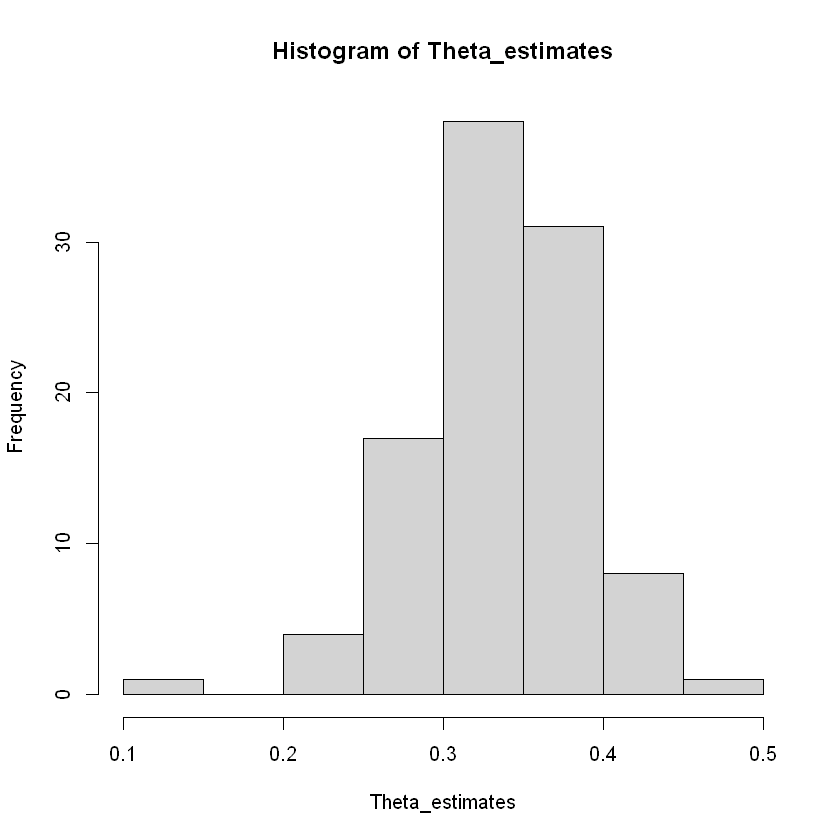

In [56]:
hist(Theta_estimates)

Nosso bootstrap está funcionando, vamos fazer o experimento monte carlo:

# Questão 1

In [58]:
R = 100

In [169]:
bootstrap_parametrico <- function(B=20,T=100,beta=1,phi=0,theta=0.3,R=2)

    {
    
    Theta_bootstrap<-numeric(B)

    Amostra_original<-simulate_glarma(T=100,beta=1,phi=0,theta=0.3,x=NULL)
    X <- Amostra_original$x
    X <- as.matrix(X)
    colnames(X) <- "Intercept"

    result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    theta_estimado<-result$delta[2]

    T=length(Amostra_original$y)
    mu<-result$mu

    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

    for (b in 1:B)
        {
        s = simulate_glarma(T=T,beta=0.5,phi=0,theta=theta,x=NULL) 
        Y_Bootstrap[,b] <- s$y
        }
    
    Theta_bootstrap <- apply(Y_Bootstrap, 2, recupera_par)

    mean_theta <- mean(Theta_bootstrap)

    IC<-quantile(Theta_bootstrap, probs = c(0.025, 0.975))
            
    return(list('theta_estimado'=theta_estimado,
                'Theta_bootstrap'=Theta_bootstrap,
                'mean_theta'=mean_theta,
                'IC'=IC))
    }

In [174]:
Questao1 <- function(B=20,T=100,beta=1,phi=0,theta=0.3,R=2)
    {
    
    theta_estimado<-numeric(R)
    mean_theta_bootstrap<-numeric(R)
    IC_bootstrap <- vector("list", R)


    for (r in 1:R)
        {
        result <- bootstrap_parametrico()
        
        mean_theta_bootstrap[r] <- result$mean_theta
        
        IC_bootstrap[[r]]<-result$IC
        
        theta_estimado[r]<-result$theta_estimado
        }
    return(list('theta_estimado'=theta_estimado,'mean_theta_bootstrap'=mean_theta_bootstrap,'IC_bootstrap'=IC_bootstrap))
    } 

In [175]:
MM_bootstrap_parametrico<-Questao1()

In [176]:
MM_bootstrap_parametrico

$theta_estimado
[1] 0.3041723 0.2913789

$mean_theta_bootstrap
[1] 0.3037464 0.3232559

$IC_bootstrap
$IC_bootstrap[[1]]
     2.5%     97.5% 
0.1989607 0.4244418 

$IC_bootstrap[[2]]
     2.5%     97.5% 
0.2214588 0.4340288

In [177]:
conferindo_cobertura_bootstrap <- function(B = 20, T = 100, beta = 1, phi = 0, theta = 0.3, R = 100) {
  
  resultado <- Questao1(B = B, T = T, beta = beta, phi = phi, theta = theta, R = R)

  theta_estimado <- resultado$theta_estimado
  IC_bootstrap <- resultado$IC_bootstrap
  
  dentro_do_intervalo <- logical(R)
  
  for (r in 1:R) {
    intervalo <- IC_bootstrap[[r]]
    dentro_do_intervalo[r] <- (theta_estimado[r] >= intervalo[1]) && (theta_estimado[r] <= intervalo[2])
  }

  cobertura_percentual <- mean(dentro_do_intervalo) * 100
  
  return(list(
    cobertura_percentual = cobertura_percentual,
    total_dentro = sum(dentro_do_intervalo),
    total_r = R
  ))
}


In [178]:
conferindo_cobertura_bootstrap(R=2)

$cobertura_percentual
[1] 100

$total_dentro
[1] 2

$total_r
[1] 2

# Bootstrap Não Paramétrico

In [123]:
e<-Amostra_original$e

In [124]:
y<-Amostra_original$y

In [125]:
mu<-Amostra_original$mu

In [126]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [127]:
e_boot <- replicate(B, sample(e, size = T, replace = TRUE))

In [128]:
gera_y_boot <- function(e,mu)
{
    
    T <- length(e)
    y <- numeric(T)
    
    for (t in 1:T)
        {
        y[t] = mu[t] + e[t]*sqrt(mu[t])
        y[t] = round(y[t])
        }
    y[y < 1e-12] <- 0
    return(data.frame(y=y))
} 

In [129]:
est_bootstrap <- function(y,X)
{
    fit <- glarma(y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    beta <- fit$delta[1]
    theta <- fit$delta[2]
    
    return(par = c(beta,theta))
}

In [130]:
gera_mu_boot <- function(e,mu,y,x,par)
{
    z <- numeric(T)

    beta <- par[1]
    theta <- par[2]
    
    for (t in 1:T) {
        z_t <- 0
        if (t > 1) z_t <-  e[t - 1] * theta

        eta <- beta * x[t] + z_t
        mu[t] <- exp(eta)
        z[t] <- z_t
      }
    return(mu)
}

In [131]:
bootstrap_n_parametrico <- function(e_boot, mu_init, y, X, B)
{

    T <- length(y)
    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)
    theta <- numeric(B)

    mu_current <- mu_init  
  
  for (b in 1:B) {
    e <- e_boot[, b]
    
    y_boot <- gera_y_boot(e, mu_current)
    y_boot<-y_boot$y
    Y_Bootstrap[, b] <- y_boot
    
    par <- est_bootstrap(y_boot, X)
    theta[b] <- par[2]
    
    mu_current <- gera_mu_boot(e, mu_current, y_boot, X, par)
  }
   
  return(theta)
}

In [132]:
theta_bootstrap <- bootstrap_n_parametrico(e_boot=e_boot,mu=mu,y=y,X=X,B=B)

In [133]:
mean(theta_bootstrap)

[1] -0.00532612

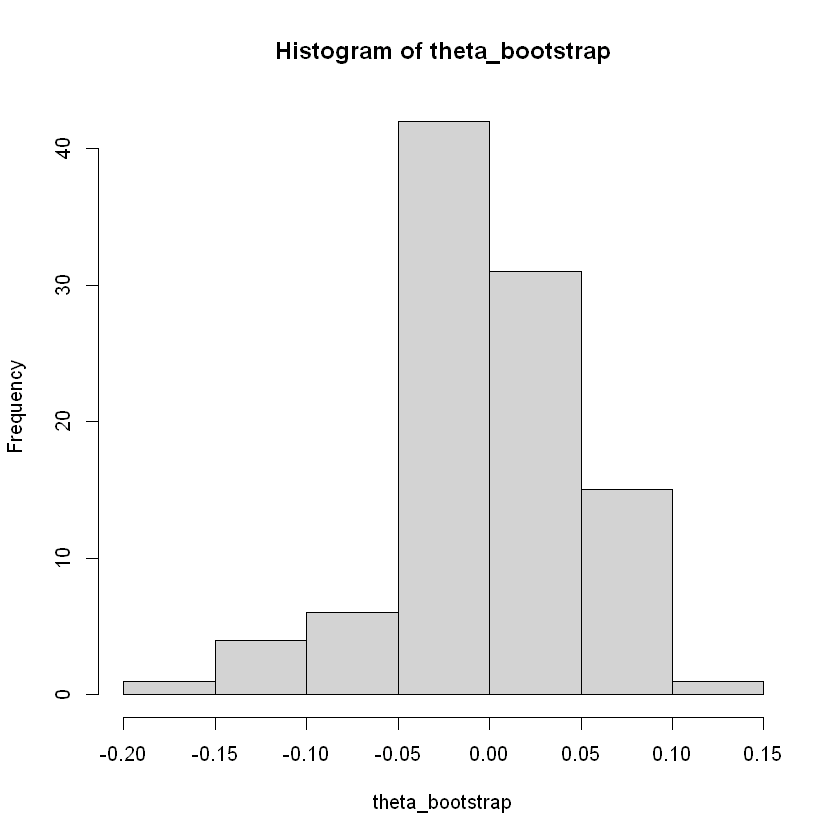

In [134]:
hist(theta_bootstrap)

# Questão 2

In [138]:
Questao2 <- function(B=20,T=100,beta=1,phi=0,theta=0.3,R=2)
    {
    
    theta_estimado<-numeric(R)
    mean_theta_bootstrap<-numeric(R)
    IC_bootstrap <- vector("list", R)

    for (r in 1:R)
        {
        Theta_bootstrap<-numeric(B)

        Amostra_original<-simulate_glarma(T=100,beta=1,phi=0,theta=0.3,x=NULL)
        X <- Amostra_original$x
        X <- as.matrix(X)
        colnames(X) <- "Intercept"

        result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
        theta_estimado[r]<-result$delta[2]
        
        e<-Amostra_original$e
        e_boot <- replicate(B, sample(e, size = T, replace = TRUE))
        
        Theta_bootstrap<-bootstrap_n_parametrico(e_boot=e_boot,B=20,mu_init=Amostra_original$mu,y=Amostra_original$y,X=X)
        
        mean_theta_bootstrap[r] <- mean(Theta_bootstrap)
        
        IC_bootstrap[[r]]<-quantile(Theta_bootstrap, probs = c(0.025, 0.975))
        }
    return(list('theta_estimado'=theta_estimado,'mean_theta_bootstrap'=mean_theta_bootstrap,'IC_bootstrap'=IC_bootstrap))
    } 

In [139]:
MM_bootstrap_n_parametrico<-Questao2()

In [140]:
MM_bootstrap_n_parametrico

$theta_estimado
[1] 0.3397110 0.3712561

$mean_theta_bootstrap
[1]  0.007958338 -0.002784084

$IC_bootstrap
$IC_bootstrap[[1]]
       2.5%       97.5% 
-0.06951670  0.08011261 

$IC_bootstrap[[2]]
      2.5%      97.5% 
-0.1579482  0.1201987

In [141]:
conferindo_cobertura_bootstrap2 <- function(B = 20, T = 100, beta = 1, phi = 0, theta = 0.3, R = 100) {
  
  resultado <- Questao2(B = B, T = T, beta = beta, phi = phi, theta = theta, R = R)

  theta_estimado <- resultado$theta_estimado
  IC_bootstrap <- resultado$IC_bootstrap
  
  dentro_do_intervalo <- logical(R)
  
  for (r in 1:R) {
    intervalo <- IC_bootstrap[[r]]
    dentro_do_intervalo[r] <- (theta_estimado[r] >= intervalo[1]) && (theta_estimado[r] <= intervalo[2])
  }

  cobertura_percentual <- mean(dentro_do_intervalo) * 100
  
  return(list(
    cobertura_percentual = cobertura_percentual,
    total_dentro = sum(dentro_do_intervalo),
    total_r = R
  ))
}


In [142]:
conferindo_cobertura_bootstrap2(R=2)

$cobertura_percentual
[1] 0

$total_dentro
[1] 0

$total_r
[1] 2

# Questão 3

In [144]:
prev_glarma <- function(y, x, beta, theta, h = 10, seed = NULL) {
  
 futuro_x <- rep(mean(x), h) 

  if (!is.null(seed)) set.seed(seed)
  
  T <- length(y)
  mu <- numeric(T)
  e <- numeric(T)
  z <- numeric(T)
  
  #passo 1, recontruir z,e,mu
    
  for (t in 1:T) {
    z_t <- if (t > 1) e[t - 1] * theta else 0
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
  # passo 2, previsão
  y_pred <- numeric(h)
  mu_pred <- numeric(h)
    
  z_t <- z[T]
  e_t <- e[T]

  for (i in 1:h) {
    z_t <- e_t * theta  
    eta <- beta * future_x[i] + z_t
    mu_pred[i] <- exp(eta)

    y_pred[i] <- mu_pred[i]
    e_t <- 0  

  }
  
  return(data.frame(
    step = 1:h,
    x = future_x,
    mu = mu_pred,
    y_pred = y_pred
  ))
}


In [183]:
sim <- simulate_glarma()

In [185]:
Y <- sim$y

In [ ]:
n<-lent

In [186]:
Y_train = Y[1:89]

In [ ]:
Y_test = Y[90:100]